# Travel time prediction

## Data Summary

### Training Data

* ~12 million observations from January 2015 through October 2015
* No missing data
* One possible data collection issue (late January) that merits investigation before using that information
* Skewed distribution as expected (durations are positive)
* Assuming latitude and longitude are not synthetic and corroborated by the point cloud, data assumed to be for New York City in 2015. 

### Test Data

* ~1.8 million observations from November and December 2015 same geo

## Modeling

### Data considerations

Evaluation period is an out of time estimate ranging two months beyond the end of the training set. As a result realtime and near realtime features are not viable. Features built on current & recent traffic state including congestion and construction or traffic route changes are key for improving the performance of the model. In addition driver features and IMU data from the ride (not available) as well as information on map data (too much effort / not in scope for a takehome) would likely improve performance. Data appears to be in the same geo - out of geo estimates are out of scope.

### Objective

Performance is being evaluated on MSE. I used MSE for training, but huber or an objective more robust to outliers is a consideration for future improvement. Working with stakeholders to understand the goals and span of a model are critical to its success. One of the risks with MSE is it skews its learning to longer duration (5 minutes off is in the same penalty for a 10 minute and 60 minute trip where we expect a 60 minute trip to have more variance - however these user experiences are likely to be considered different). In addition, MSE assumes symmetry in the perception of error (even though this model’s residuals are not quite symmetric) however if over predicting vs under predicting lead to different user experiences we may not be properly encoding that incentive in our training.

### Approach

#### Evaluation

Since the model will predict on a two month hold out, I replicated that in my evaluation. Training the model on data from February (note data collection issue at end of Jan and we have plenty of data relative to compute) through August and using September and October to evaluate performance metrics. If there were longer term time varying effects I would retrain the model through October for final predictions, but I have not investigated that yet and given the stationarity as well as simplicity and confidence in the evaluation metrics I did not. The February through August trained model is used to predict November and December. Not having a full year of data to test and evaluate this workflow makes it challenging to validate that assumption. 
Performance metrics on the out of time estimate:

#### Features

The two types of information available are 

1. location - the start and end latitude & longitude
2. start time of the ride

Since a trip needs a route, having information about the route (and ideally historical IMU data) could dictate a different approach, but with what's provided I built two types of features. 

1. Location (8)
    1. 2 from the angle between the start and end of the latitude and longitude (this could be extended with haversine distance as a third element) - these are `lat_delta` and `lng_delta`
    2. The latitude and longitude for the start and end locations are input as raw features that xgboost buckets. For a first pass / takehome tuning a reasonable xgboost model is efficient (note my personal computer is old and slow). To get some 2d localization information, a rough first pass is to bucket the map into 2d cells and encode the 2d cells as categorical / enums. While there are substantially better approaches to localizing the “trip” (even with route unavailable) through deep learning with convolutional layers, takehomes are on personal time on personal machines So for time and machine capacity I descoped that approach as well as alternatives, such as HDBSCAN or building a quadtree and using the clusters / indexing, which are other potential paths forward. (note the cells account for density). Note I tried kmeans encoding cluster id and distance to cluster centers but there was not substantial improvement. It’s possible that approach with tuning is better than laying down a 2d grid, but for a ~4 hour assignment that’s out of scope.
2.  Start time (6): Since 11:59 PM is next to 12:00 AM unless there is reason to believe that boundary is key, projecting the time of day onto the unit circle yields two features where in the 2d space 11:59 PM is near 12:00 AM and opposite 11:59 AM. These features are designed to help understand time of day based traffic considerations. Similarly commuting and trip types are expected to be different from the weekday vs weekend. This is encoded as a bool through the same process via time of week. Last a US holiday calendar is used to infer business days (expected to impact commute similar to weekend though could have different effect due to macro change in travel plans) 

Summary

1. 2 distance features
2. 4 raw positional features
3. 2 2d cell features treated as categorical (start, end)
4. 2 time of day features (x, y)
5. 2 time of week features (x, y)
6. 2 indicators: is weekend and is holiday

Note - categorical features transformed with a James Stein encoder

#### Sampling

(again) for compute availability and to enable iteration, combined with the redundancy of some data I tested an iterative sampling approach - drawing from active learning . Training on a subset of the data and iteratively pulling in observations with largest residuals and retraining. This approach has some outlier risk and did not prove particularly effective at improving performance but with more time I believe it could. To combat outliers and focus on the core use case of the model I dropped records that were in greater than 100 minutes. Improving outlier performance and understanding the expected and desired scope of the model are key areas for future work (see huber loss discussion above as one option).

#### Clipping

Last, with more complex models we may see more spurious results in new environments -to guard against that I used a policy layer - setting the min prediction to 1(s).

#### Out of time model performance

* observations evaluated:  2,311,214
*  r2 score: 0.69
* mean_absolute_error: 202
* mean_absolute_percentage_error: 42.2%
* mean_squared_error: 167014



In [2]:
from analysis import notebook as nb

In [3]:
nb.summary()

(12089610, 7)


,is_null_fraction,schema,0,1,2,3,4
row_id,0.0,int64,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
start_lng,0.0,float64,-7.399311e+01,-7.397192e+01,-7.395325e+01,-7.398662e+01,-7.396886e+01
start_lat,0.0,float64,4.072429e+01,4.076275e+01,4.076582e+01,4.073935e+01,4.075732e+01
end_lng,0.0,float64,-7.400098e+01,-7.396570e+01,-7.395284e+01,-7.394916e+01,-7.398252e+01
end_lat,0.0,float64,4.073522e+01,4.077143e+01,4.077245e+01,4.080516e+01,4.077130e+01
start_timestamp,0.0,int64,1.422174e+09,1.420567e+09,1.420567e+09,1.420103e+09,1.420690e+09
duration,0.0,int64,6.790000e+02,2.370000e+02,3.560000e+02,1.141000e+03,4.930000e+02


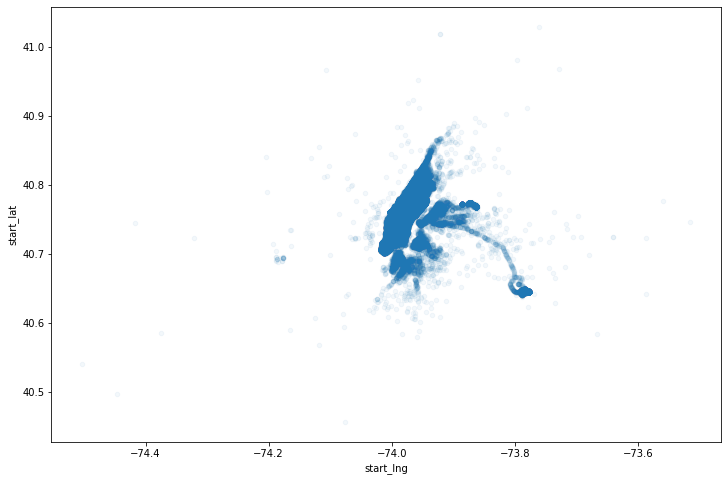

In [4]:
nb.scatter(sample=200000, prefix='start', figsize=(12, 8), alpha=.05)

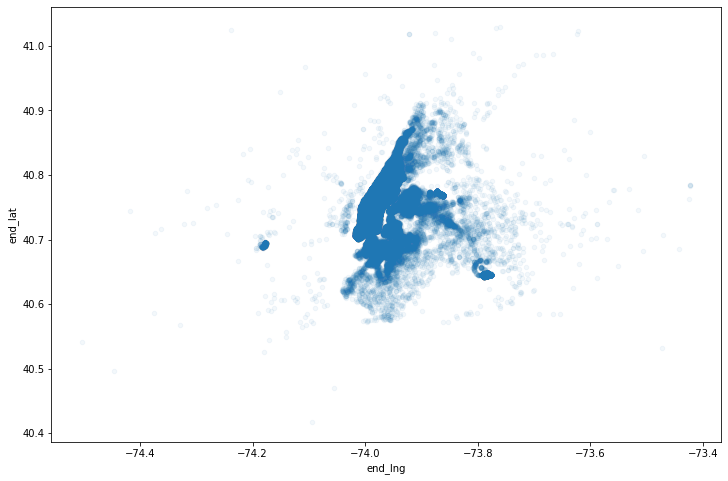

In [5]:
nb.scatter(sample=200000, prefix='end', figsize=(12, 8), alpha=.05)

'number records: 12089610'

,duration - minutes
mean,13.951640
std,11.801585
min,0.016667
25%,6.650000
50%,11.033333
75%,17.833333
90%,26.916667
95%,34.483333
99.7%,70.600000
99.99%,215.441805


'sample size for histogram: 200000'

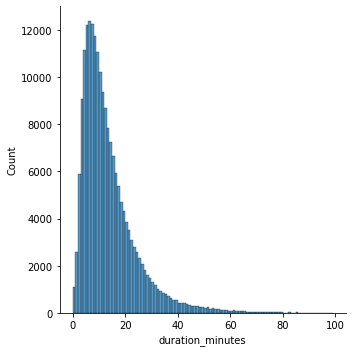

In [6]:
nb.duration_summary()

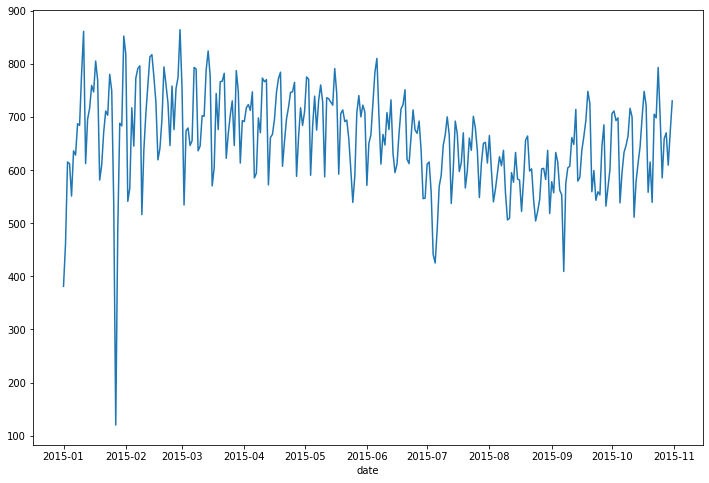

In [7]:
nb.rides_by_day(sample=200000)

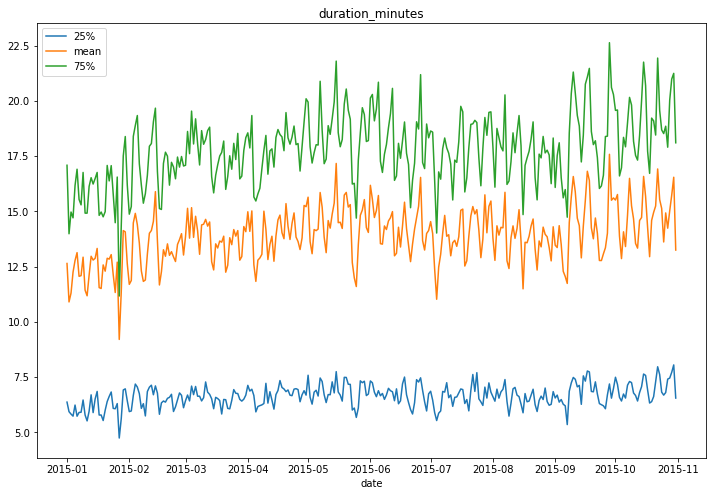

In [8]:
nb.duration_by_day(sample=200000)

## Model performance summary

'residuals (seconds)'

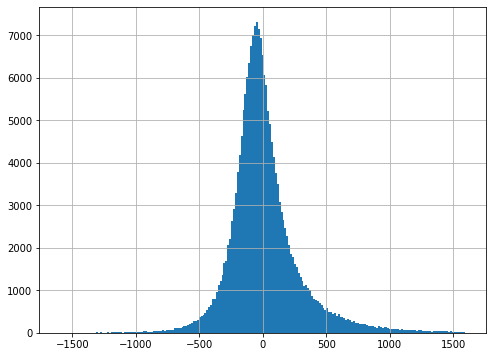

In [9]:
nb.residual_hist()

'abs(residuals) (seconds)'

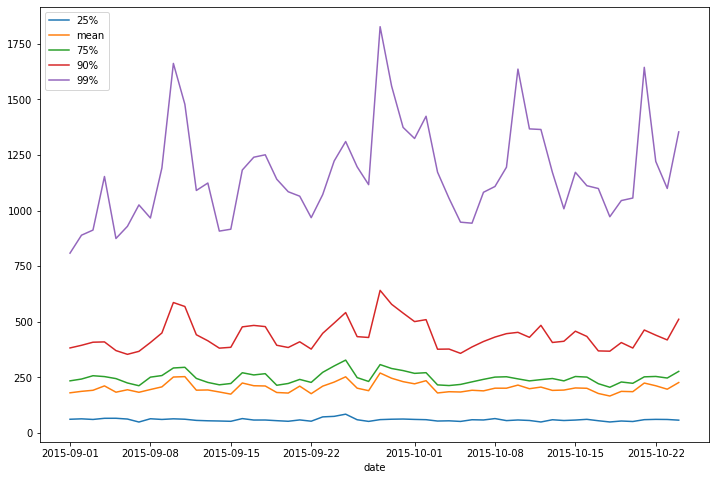

In [10]:
nb.residual_by_day()

'residuals (seconds)'

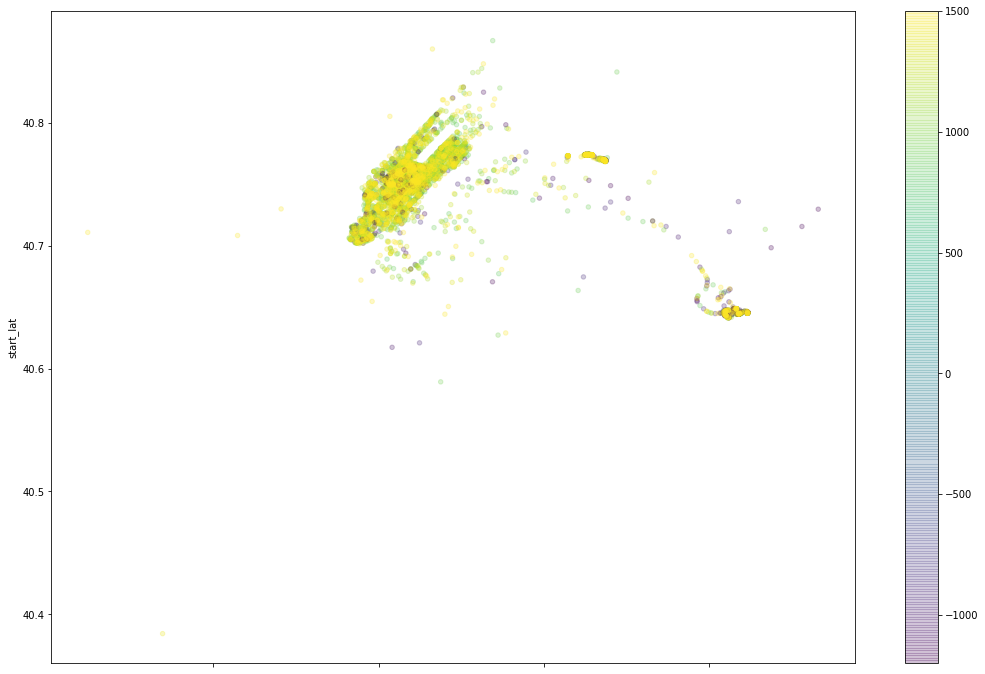

In [11]:
nb.residual_scatter()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


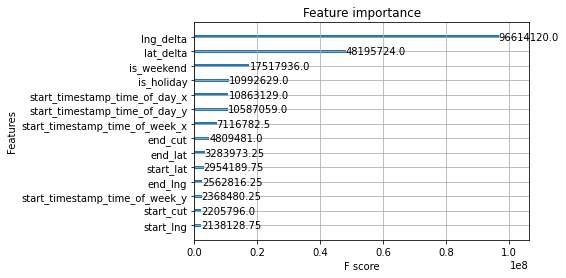

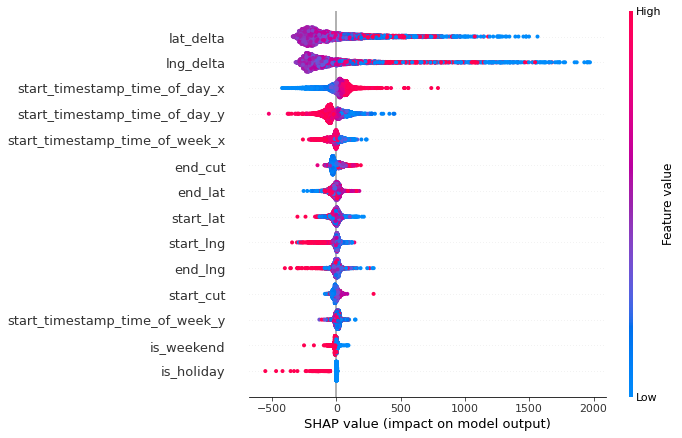

In [12]:
nb.load_explaination(data='data/train_model_xgb.csv')